In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

Import csv data from https://data.sccer-jasm.ch/demand-hourly-profile-retrofits-cesar/jasm-demand-hourly-profile-retrofits-cesar-2020-09-17.zip
(https://www.sciencedirect.com/science/article/pii/S0378778819319486)

In [3]:
os.chdir('/home/MA')

In [4]:
PV_production = pd.read_pickle('Calculations/Hawaii/PV_production_Hawaii.pkl')

Scale production from 6 kWp to 460 MWp

In [5]:
PV_production = PV_production/6*460000

Source for total load data:

https://uhero.hawaii.edu/wp-content/uploads/2019/08/TOURates_8-2.pdf

In [6]:
load_oahu_MW = np.tile([675,640,620,625,670,750,830,850,860,855,850,850,855,870,890,925,970,1050,1300,1100,970,900,800,730],365)

In [7]:
load_oahu_KW = load_oahu_MW * 1000

In [8]:
total_elec_load = load_oahu_KW

In [9]:
power_balance = pd.DataFrame()

In [10]:
power_balance['from PV'] = PV_production

In [11]:
power_balance.head(24)

from PV
month day hour            
1     1   0          0.000
          1          0.000
          2          0.000
          3          0.000
          4          0.000
          5          0.000
          6          0.000
          7          0.000
          8      91897.512
          9     201210.164
          10    244910.670
          11    349445.302
          12    372758.286
          13    287916.760
          14    323089.556
          15    255175.984
          16    192433.778
          17     97342.578
          18         0.000
          19         0.000
          20         0.000
          21         0.000
          22         0.000
          23         0.000

In [12]:
power_balance['consumption'] = total_elec_load

In [13]:
power_balance['exchange grid'] = PV_production - total_elec_load

In [14]:
power_balance['to Grid'] = (PV_production - total_elec_load).clip(lower=0)

In [15]:
power_balance['from Grid'] = (total_elec_load - PV_production).clip(lower=0)

In [16]:
power_balance = power_balance.fillna(0)

In [17]:
power_balance.head(24)

from PV  consumption  exchange grid  to Grid    from Grid
month day hour                                                              
1     1   0          0.000       675000    -675000.000      0.0   675000.000
          1          0.000       640000    -640000.000      0.0   640000.000
          2          0.000       620000    -620000.000      0.0   620000.000
          3          0.000       625000    -625000.000      0.0   625000.000
          4          0.000       670000    -670000.000      0.0   670000.000
          5          0.000       750000    -750000.000      0.0   750000.000
          6          0.000       830000    -830000.000      0.0   830000.000
          7          0.000       850000    -850000.000      0.0   850000.000
          8      91897.512       860000    -768102.488      0.0   768102.488
          9     201210.164       855000    -653789.836      0.0   653789.836
          10    244910.670       850000    -605089.330      0.0   605089.330
          11    349445.302       850000    -500554.698      0.0   500554.698
          12    372758.286       855000    -482241.714      0.0   482241.714
          13    287916.760       870000    -582083.240      0.0   582083.240
          14    323089.556       890000    -566910.444      0.0   566910.444
          15    255175.984       925000    -669824.016      0.0   669824.016
          16    192433.778       970000    -777566.222      0.0   777566.222
          17     97342.578      1050000    -952657.422      0.0   952657.422
          18         0.000      1300000   -1300000.000      0.0  1300000.000
          19         0.000      1100000   -1100000.000      0.0  1100000.000
          20         0.000       970000    -970000.000      0.0   970000.000
          21         0.000       900000    -900000.000      0.0   900000.000
          22         0.000       800000    -800000.000      0.0   800000.000
          23         0.000       730000    -730000.000      0.0   730000.000

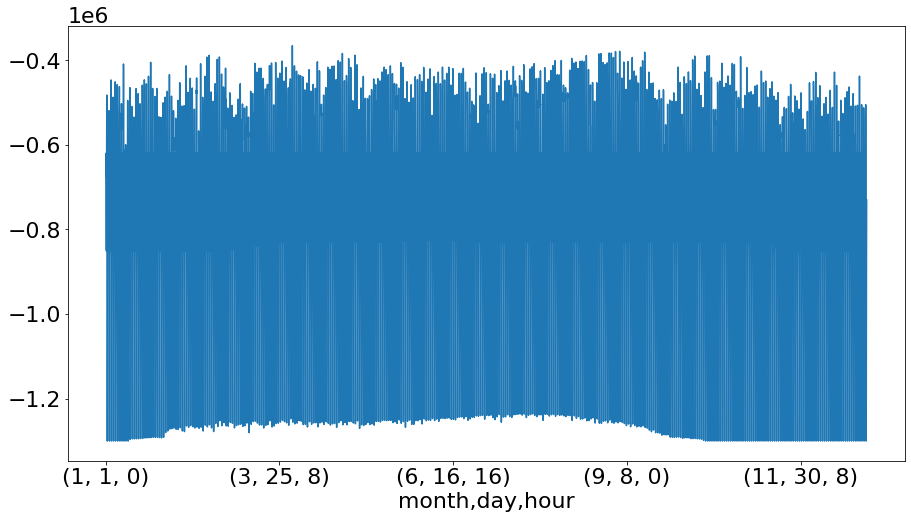

In [18]:
power_balance['exchange grid'].plot();

In [19]:
power_balance.to_pickle('Calculations/Hawaii/power_balance_oahu.pkl')

**No storage calculations**

Self-consumption share

In [20]:
sum(power_balance['consumption'] - power_balance['from Grid'])/sum(power_balance['from PV'])

1.0

Curtailment calculation

In [21]:
sum(power_balance['to Grid'])/sum(power_balance['from PV'])

0.0

PV share without storage

In [22]:
sum(power_balance['to Grid'])/sum(power_balance['consumption'])

0.0

In [23]:
power_balance = pd.read_pickle('Calculations/Hawaii/power_balance_oahu.pkl')

Define battery size

In [24]:
battery_size = 6

In [25]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [26]:
eta_discharge = 0.85

Define function for battery dispatch

In [27]:
from Battery_dispatch_function import BatteryDispatch

In [28]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

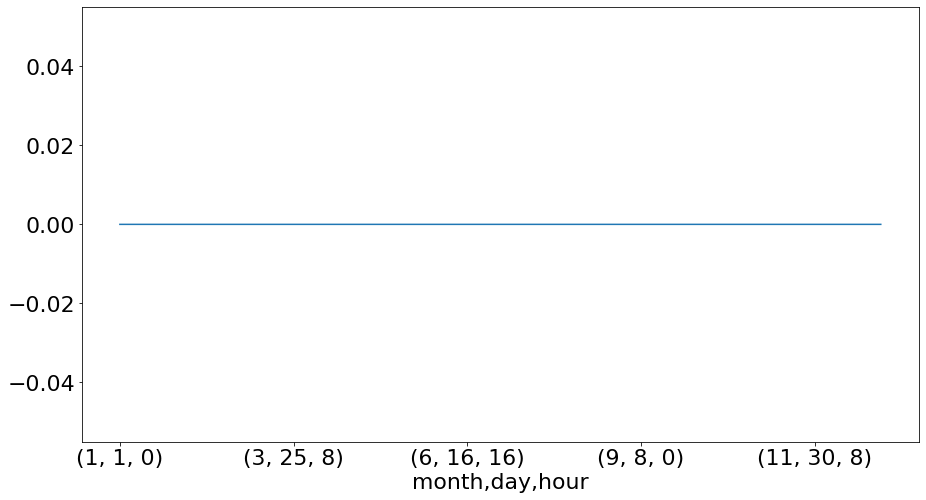

In [29]:
power_balance['SoC'].plot(); 

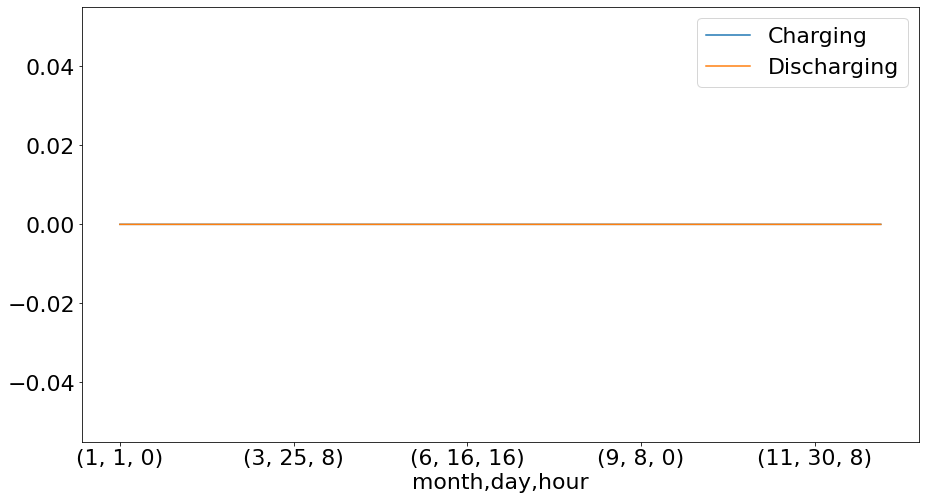

In [30]:
power_balance[['Charging', 'Discharging']].plot(); 

In [31]:
sum(power_balance['Charging'])

0.0

In [32]:
sum(power_balance['Discharging'])

0.0

Check how many cycles were carried out

In [33]:
sum(power_balance['Charging'])/battery_size

0.0

In [34]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

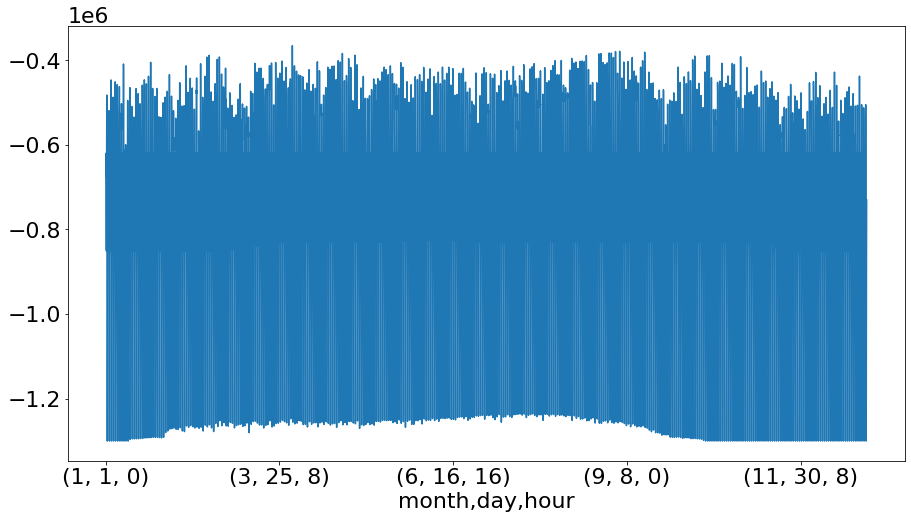

In [35]:
power_balance['exchange grid new'].plot();

Self-consumption share with BESS

In [36]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

1.0

Curtailment calculation with BESS

In [37]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

0.0

PV share with BESS

In [38]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.1366384017576634

Losses in the battery system

In [39]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.0

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [40]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

0.0

**CO$_2$ calculations**

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [42]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [43]:
power_balance = pd.read_pickle('Calculations/Hawaii/power_balance_hawaii.pkl')

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [44]:
battery_lifetime = 15 # years

Grid emissions for Hawaii from https://www.eia.gov/electricity/state/hawaii/ 
Converted from lbs/MWh to g/kWh

In [45]:
grid_emissions_hawaii= 751.148965 # g CO2/kWh

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [46]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

In [47]:
battery_size = [3000000]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [48]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge)
    results['yearly_savings_kWh'].values[i] = sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

TypeError: BatteryDispatch() missing 2 required positional arguments: 'max_c_charge' and 'max_c_discharge'

In [ ]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * battery_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [ ]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_hawaii / 1000000

For a lifetime of 15 years, this corresponds to a gross saving of 

In [ ]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * battery_lifetime

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [ ]:
CO2_intensity_China = 637

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance

In [ ]:
results['total_elec_battery_prod'] = elec_battery_prod * results['battery_size']/0.8

Net saving of battery deployment

In [ ]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [ ]:
results['net_CO2_savings'] = results['total_CO2_battery_prod'] + results['total_CO2_grid_reduced']

In [ ]:
results

**EROI calculations**

Electricity intensity used for PV production

In [ ]:
PV_lifetime = 25 #years

In [ ]:
PV_production_hourly = pd.read_pickle('Calculations/Hawaii/PV_production_Hawaii.pkl')

In [ ]:
yearly_PV_production = sum(PV_production_hourly)

In [ ]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [ ]:
PV_size = 460000 #kW_p

In [ ]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [ ]:
results['ESOI'] = -results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [ ]:
results['EROI_gen'] = yearly_PV_production * PV_lifetime / results['total_elec_PV_prod']

In [ ]:
results

In [ ]:
results['EROI_grid'] = (1 - results['curtailment'] + eta_discharge * results['curtailment']) / (1/results['EROI_gen'] + results['curtailment'] / results['ESOI'])

In [ ]:
results['ESOI'] = results['ESOI'].fillna(0)
results['EROI_grid'] = results['EROI_grid'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [ ]:
results.set_index("battery_size",drop=True,inplace=True)

In [ ]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI');

In [ ]:
results['EROI_grid'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');

For case of feed-in, use different EROI_gen